# Graphical Models and Bayesian Networks with PyMC3

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import pymc3 as pm
import matplotlib.pyplot as plt
import daft

# Sprinkler Model

## Representation

Consider the following example, in which all nodes are binary, i.e., have two possible values, which we will denote by T (true) and F (false).


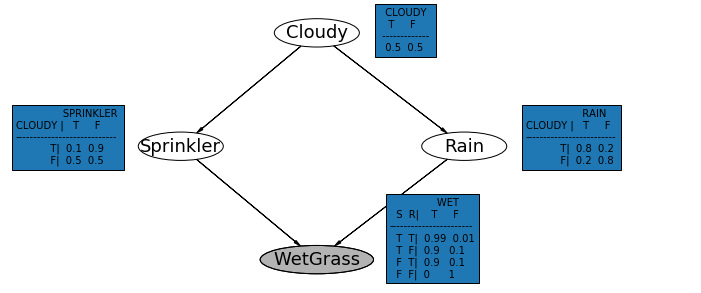

In [2]:
pgm = daft.PGM(shape=[6, 2.4], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')
pgm.add_node(daft.Node('c', 'Cloudy', 2.7, 2.2, aspect=3))
pgm.add_node(daft.Node('r', 'Rain', 4, 1.2, aspect=3))
pgm.add_node(daft.Node('s', 'Sprinkler', 1.5, 1.2, aspect=3))
pgm.add_node(daft.Node('w', 'WetGrass', 2.7, 0.2, aspect=4, observed=True))
pgm.add_edge('c', 'r')
pgm.add_edge('c', 's')
pgm.add_edge('r', 'w')
pgm.add_edge('s', 'w')

# CPDs
pgm.add_plate(daft.Plate([3.2, 2, 0, 0], label="  CLOUDY \n"+
                                                  "   T     F \n"+
                                                  " ------------- \n  0.5  0.5"))

pgm.add_plate(daft.Plate([4.5, 1, 0, 0], label="                  RAIN \n"+
                                                 "CLOUDY |   T     F \n"+
                                                 "-------------------------\n"+
                                                 "           T|  0.8  0.2\n"+
                                                 "           F|  0.2  0.8"))

pgm.add_plate(daft.Plate([0, 1, 0, 0], label="               SPRINKLER \n"+
                                                 "CLOUDY |   T     F \n"+
                                                 "----------------------------\n"+
                                                 "           T|  0.1  0.9\n"+
                                                 "           F|  0.5  0.5"))


pgm.add_plate(daft.Plate([3.3, 0, 0, 0], label="               WET \n"+
                                                 "  S  R|    T     F \n"+
                                                 "-----------------------\n"+
                                                 "  T  T|  0.99  0.01\n"+
                                                 "  T  F|  0.9   0.1\n"+
                                                 "  F  T|  0.9   0.1\n"+
                                                 "  F  F|  0      1"))


pgm.render()

#pgm.figure.savefig("wetgrass.png", dpi=500)



We see that the event "grass is wet" (W=true) has two possible causes: either the water sprinker is on (S=true) or it is raining (R=true). The strength of this relationship is shown in the table. For example, we see that Pr(W=true | S=true, R=false) = 0.9 (second row), and hence, Pr(W=false | S=true, R=false) = 1 - 0.9 = 0.1, since each row must sum to one. Since the C node has no parents, its CPT specifies the prior probability that it is cloudy (in this case, 0.5). (Think of C as representing the season: if it is a cloudy season, it is less likely that the sprinkler is on and more likely that the rain is on.) 

## Model

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [cloudy, rain, sprinkler, grass_wet]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:09<00:00, 2302.63draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ismael/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


   Cloudy  Rain  Sprinkler  Grass Wet  Rain Probability  \
0       1     1          0          1               0.8   
1       1     0          1          1               0.8   
2       1     1          1          1               0.8   
3       0     1          0          1               0.2   
4       0     0          1          1               0.2   

   Sprinkler Probability  Grass Wet Probability  
0                    0.1                   0.90  
1                    0.1                   0.90  
2                    0.1                   0.99  
3                    0.5                   0.90  
4                    0.5                   0.90  


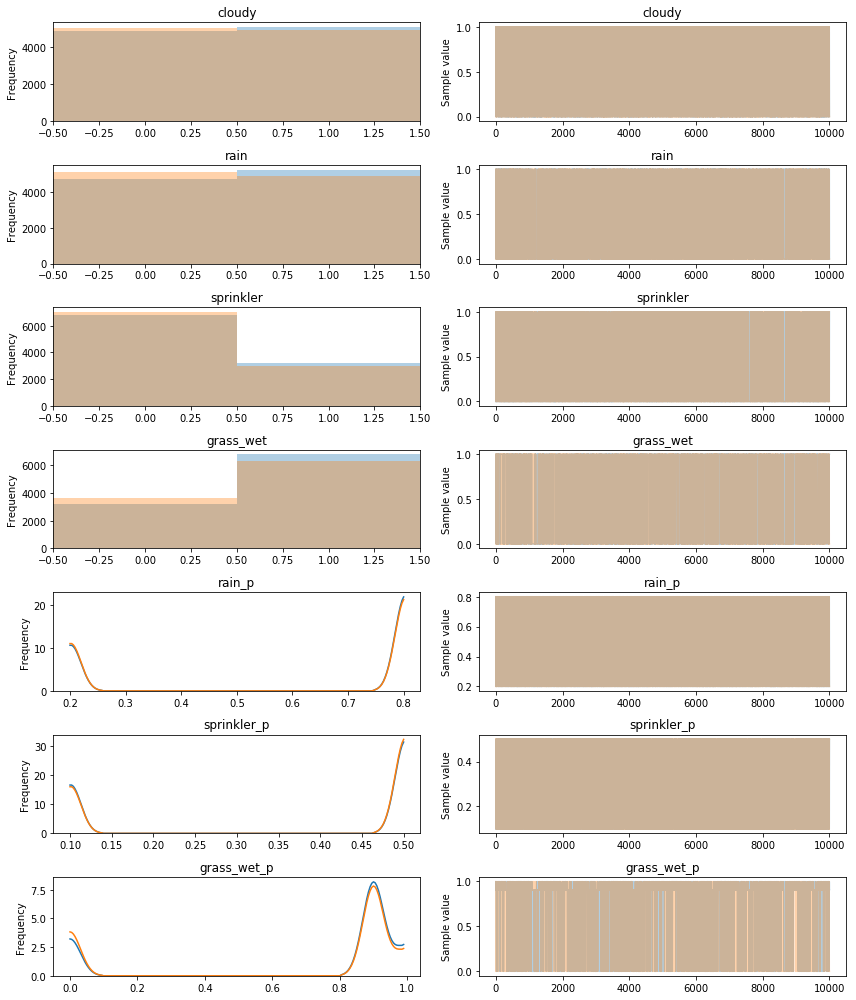

In [3]:
model = pm.Model()

with model:
    cloudy = pm.Bernoulli('cloudy', 0.5)
    
    rain_p = pm.Deterministic('rain_p', pm.math.switch(cloudy, 0.8, 0.2))
    rain = pm.Bernoulli('rain', rain_p)

    sprinkler_p = pm.Deterministic('sprinkler_p', pm.math.switch(cloudy, 0.1, 0.50))
    sprinkler = pm.Bernoulli('sprinkler', sprinkler_p)
 
    grass_wet_p = pm.Deterministic('grass_wet_p', pm.math.switch(rain, pm.math.switch(sprinkler, 0.99, 0.90), pm.math.switch(sprinkler, 0.90, 0.0)))
    grass_wet = pm.Bernoulli('grass_wet', grass_wet_p)

    trace =  pm.sample(10000, progressbar=True)

pm.traceplot(trace)

dictionary = {
              'Cloudy': [1 if ii else 0 for ii in trace['cloudy'].tolist() ],
              'Rain': [1 if ii else 0 for ii in trace['rain'].tolist() ],
              'Sprinkler': [1 if ii else 0 for ii in trace['sprinkler'].tolist() ],
              'Grass Wet': [1 if ii else 0 for ii in trace['grass_wet'].tolist() ],
              'Rain Probability': [ii for ii in trace['rain_p'].tolist()],
              'Sprinkler Probability': [ii for ii in trace['sprinkler_p'].tolist()],
              'Grass Wet Probability': [ii for ii in trace['grass_wet_p'].tolist()],
              }
df = pd.DataFrame(dictionary)
print(df.head())

## Inference

The most common task we wish to solve using Bayesian networks is probabilistic inference. For example, consider the water sprinkler network, and suppose we observe the fact that the grass is wet. There are two possible causes for this: either it is raining, or the sprinkler is on. Which is more likely? We can use Bayes' rule to compute the posterior probability of each explanation (where 0==false and 1==true). 

* What is the TOTAL probability that grass is wet? (Pr[W=1])

In [4]:
p_wet = df[df['Grass Wet'] == 1].shape[0] / df['Grass Wet'].shape[0]
print(p_wet)

0.65565


* Given grass is wet, what is the probability that it was rained? (Pr[R=1|W=1])

In [5]:
p_rain_wet = (df[(df['Rain'] == 1) & (df['Grass Wet'] == 1)].shape[0]) / df[df['Grass Wet'] == 1].shape[0]
print(p_rain_wet)

0.7054068481659422


* Given grass is wet, what is the probability that sprinkler was opened? (Pr[S=1|W=1])

In [6]:
p_sprinkler_wet = (df[(df['Sprinkler'] == 1) & (df['Grass Wet'] == 1)].shape[0]) / df[df['Grass Wet'] == 1].shape[0]
print(p_sprinkler_wet)

0.43384427667200487


* Given sprinkler is off and it does not rain, what is the probability that grass is wet? (Pr[W=1|S=0,R=0])

In [7]:
p_not_sprinkler_rain_wet = (df[(df['Sprinkler'] == 0) & (df['Rain'] == 0) & (df['Grass Wet'] == 1)].shape[0]) / df[df['Grass Wet'] == 1].shape[0]
print(p_not_sprinkler_rain_wet)

0.0


## Explaining away

In the above example, notice that the two causes "compete" to "explain" the observed data. Hence S and R become conditionally dependent given that their common child, W, is observed, even though they are marginally independent. For example, suppose the grass is wet, but that we also know that it is raining. Then the posterior probability that the sprinkler is on goes down, Pr(S=1|W=1,R=1): 

In [8]:
p_sprinkler_rain_wet = (df[(df['Sprinkler'] == 1) & (df['Rain'] == 1) & (df['Grass Wet'] == 1)].shape[0]) / df[(df['Rain'] == 1) & (df['Grass Wet'] == 1)].shape[0]
print(p_sprinkler_rain_wet)

0.1974054054054054


# Student Model

## Representation

Consider the following example:

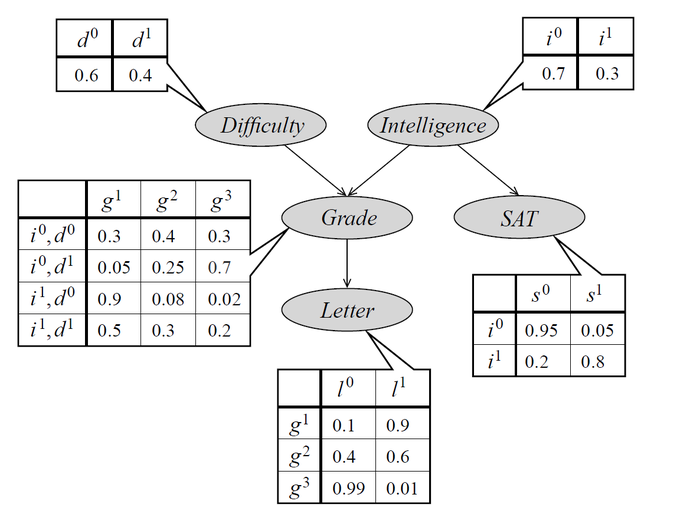

In [9]:
from IPython.display import Image
Image(filename='figures/student_model.png')

## Model

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [difficulty, intelligence, sat, letter]
>Metropolis: [grade]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:14<00:00, 1460.38draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ismael/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


  Intelligence Difficulty SAT Grade Letter  SAT Probability  \
0           i0         d0  s0    g1     l1             0.95   
1           i1         d1  s1    g1     l1             0.20   
2           i1         d0  s1    g1     l0             0.20   
3           i1         d1  s1    g1     l0             0.20   
4           i1         d0  s1    g1     l1             0.20   

   Grade Probability  Letter Probability  
0    [0.3, 0.4, 0.3]                 0.1  
1    [0.5, 0.3, 0.2]                 0.1  
2  [0.9, 0.08, 0.02]                 0.1  
3    [0.5, 0.3, 0.2]                 0.1  
4  [0.9, 0.08, 0.02]                 0.1  


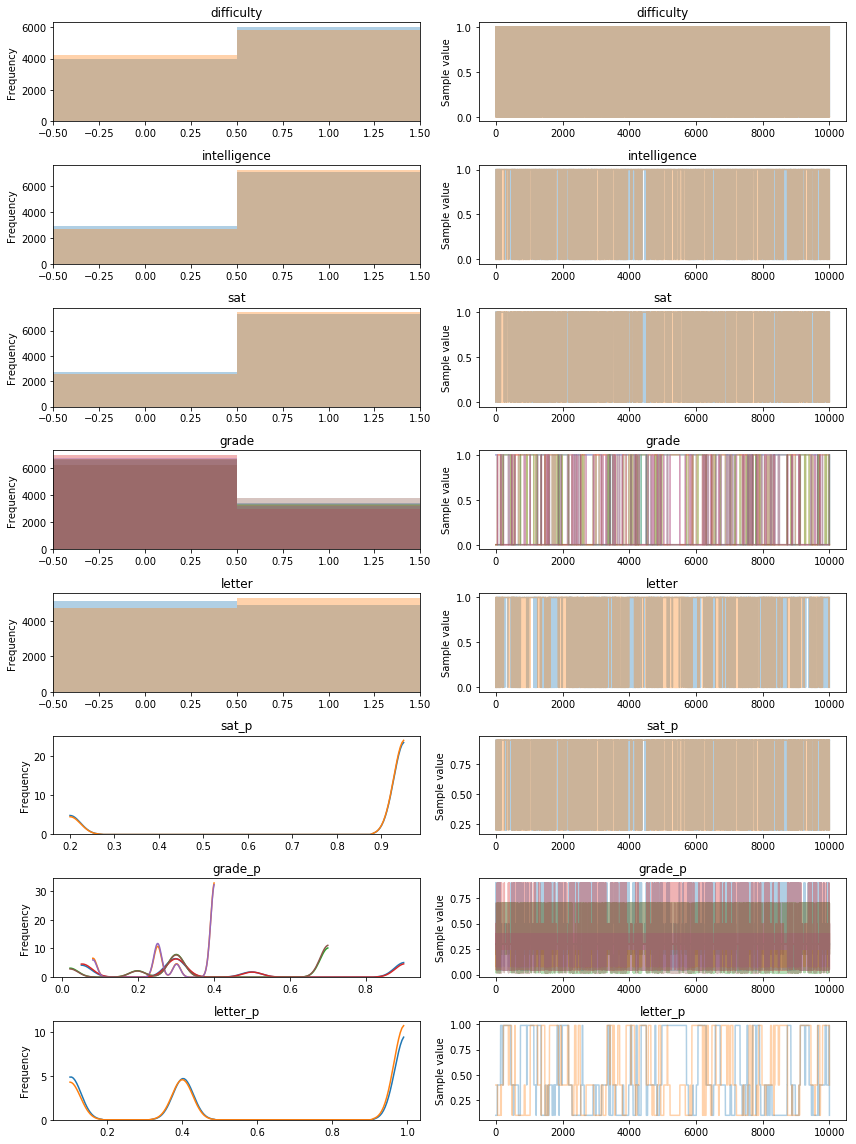

In [10]:
model = pm.Model()

with model:
    difficulty = pm.Bernoulli('difficulty', 0.6)
    intelligence = pm.Bernoulli('intelligence', 0.7)
    
    sat_p = pm.Deterministic('sat_p', pm.math.switch(intelligence, 0.95, 0.2))
    sat = pm.Bernoulli('sat', sat_p)
 
    grade_p = pm.Deterministic('grade_p', pm.math.switch(intelligence, pm.math.switch(difficulty, np.array([0.3, 0.4, 0.3]), np.array([0.05, 0.25, 0.7])), pm.math.switch(difficulty, np.array([0.9, 0.08, 0.02]), np.array([0.5, 0.3, 0.2]))))
    grade = pm.Multinomial('grade', n=1, p=grade_p, shape=3)
    
    letter_p = pm.Deterministic('letter_p', pm.math.switch(grade[0], 0.1, pm.math.switch(grade[1], 0.4, 0.99)))
    letter = pm.Bernoulli('letter', letter_p)
    
    trace =  pm.sample(10000, progressbar=True)

pm.traceplot(trace)

dictionary = {
              'Intelligence': ['i0' if ii else 'i1' for ii in trace['intelligence'].tolist() ],
              'Difficulty': ['d0' if ii else 'd1' for ii in trace['difficulty'].tolist() ],
              'SAT': ['s0' if ii else 's1' for ii in trace['sat'].tolist() ],
              'Grade': ['g1' if ii[0] else 'g2' if ii[1] else 'g3' for ii in trace['grade'].tolist() ],
              'Letter': ['l0' if ii else 'l1' for ii in trace['letter'].tolist() ],
              'SAT Probability': [ii for ii in trace['sat_p'].tolist()],
              'Grade Probability': [ii for ii in trace['grade_p'].tolist()],
              'Letter Probability': [ii for ii in trace['letter_p'].tolist()],
              }
df = pd.DataFrame(dictionary)
print(df.head())

## Inference

### Causal reasoning (Predicting downstrean effects of evidence)

* What is the probability of strong letter? (Pr[L=l1])

In [11]:
p_letter = df[df['Letter'] == 'l1'].shape[0] / df['Letter'].shape[0]
print(p_letter)

0.4899


* What is the probability of strong letter given low intelligence? (Pr[L=l0|I=i0])

In [12]:
p_letter_low_intelligence_grade_c = (df[(df['Letter'] == 'l1') & (df['Intelligence'] == 'i0')].shape[0]) / df[(df['Intelligence'] == 'i0')].shape[0]
print(p_letter_low_intelligence_grade_c)

0.3822423398328691


* What is the probability of strong letter given low intelligence and easy class? (Pr[L=l0|I=i0,D=d0])

In [13]:
p_letter_low_intelligence_grade_c = (df[(df['Letter'] == 'l1') & (df['Intelligence'] == 'i0') & (df['Difficulty'] == 'd0')].shape[0]) / df[(df['Intelligence'] == 'i0') & (df['Difficulty'] == 'd0')].shape[0]
print(p_letter_low_intelligence_grade_c)

0.49865260691271235


### Evidential Reasoning (From effects to causes)

* What is the probability of high intelligence? (Pr[I=i1])

In [14]:
p_intelligence = df[df['Intelligence'] == 'i1'].shape[0] / df['Intelligence'].shape[0]
print(p_intelligence)

0.282


* What is the probability of high intelligence given grade C? (Pr[I=i1|G=g3])

In [15]:
p_intelligence_grade_c = (df[(df['Intelligence'] == 'i1') & (df['Grade'] == 'g3')].shape[0]) / df[(df['Grade'] == 'g3')].shape[0]
print(p_intelligence_grade_c)

0.07015324054548011


* What is the probability of high intelligence given a weak letter? (Pr[I=i1|L=l0])

In [16]:
p_intelligence_weak_letter = (df[(df['Intelligence'] == 'i1') & (df['Letter'] == 'l0')].shape[0]) / df[(df['Letter'] == 'l0')].shape[0]
print(p_intelligence_weak_letter)

0.1304646147814154


* What is the probability of high intelligence given a weak letter and grade C? (Pr[I=i1|L=l0,G=g3])

In [17]:
p_intelligence_weak_letter_grace_c = (df[(df['Intelligence'] == 'i1') & (df['Letter'] == 'l0') & (df['Grade'] == 'g3')].shape[0]) / df[(df['Letter'] == 'l0') & (df['Grade'] == 'g3')].shape[0]
print(p_intelligence_weak_letter_grace_c)

0.06988636363636364


## References

* https://www.cs.ubc.ca/~murphyk/Bayes/bnintro.html
* https://pdfs.semanticscholar.org/presentation/8982/17902aabd84db5f798b375b73d0492a97cda.pdf